In [1]:
import h5py
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import os 
import healpy as hp
import matplotlib.colors as mcolors
import seaborn as sns
sns.set()
sns.set_style("darkgrid", {'grid.linestyle': '--', 'font.serif':'Times New Roman'})
sns.set_context("poster", 1.5, {"lines.linewidth": 2.0})

def rpm_to_period(rpm):
    return 60.0 / rpm

def get_data(path):
    with h5py.File(path, 'r') as f:
        # argsグループからデータを取得
        args_group = f['args']
        spin_n = args_group['spin_n'][()]
        spin_m = args_group['spin_m'][()]
        lmax4likelihood = args_group['lmax4likelihood'][()]
        rho = args_group['rho'][()]
        chi = args_group['chi'][()]
        ss = {key: value[()] for key, value in args_group['ss'].items()}
        
        # quantifyグループからデータを取得
        quantify_group = f['quantify']
        n = quantify_group['n'][()]
        m = quantify_group['m'][()]
        mean = quantify_group['mean'][()]
        std = quantify_group['std'][()]
        hitmap_std = quantify_group['hitmap_std'][()]

        # delta_rのデータを取得
        delta_r = f['delta_r'][()]
        return {"ss":ss, "n":n, "m":m, "hitmap_std":hitmap_std, "mean":mean, "std":std, "delta_r":delta_r}
    
def get_hitmap(path):
    with h5py.File(path, 'r') as f:
        # argsグループからデータを取得
        args_group = f['args']
        spin_n = args_group['spin_n'][()]
        spin_m = args_group['spin_m'][()]
        lmax4likelihood = args_group['lmax4likelihood'][()]
        rho = args_group['rho'][()]
        chi = args_group['chi'][()]
        hitmap = f['hitmap'][:]
        ss = {key: value[()] for key, value in args_group['ss'].items()}
        
        # quantifyグループからデータを取得
        quantify_group = f['quantify']
        n = quantify_group['n'][()]
        m = quantify_group['m'][()]
        mean = quantify_group['mean'][()]
        std = quantify_group['std'][()]

        # delta_rのデータを取得
        delta_r = f['delta_r'][()]
        return {"ss":ss, "n":n, "m":m, "mean":mean, "std":std, "delta_r":delta_r, "hitmap":hitmap}

def f(path, N, M):
    d = get_data(path + "./output_1.h5")
    index = np.where((d["n"]==N) & (d["m"]==M))
    return index[0][0]

def get_griddata(path, fill=True):
    step = 3
    alpha = np.arange(step, 95-step, step)
    T_alpha = np.logspace(3.1, 7.2, 50)
    hitmap_std = np.zeros([len(alpha), len(T_alpha)])
    xlink_mean = np.zeros([len(alpha), len(T_alpha), 55])
    xlink_std = np.zeros([len(alpha), len(T_alpha), 55])
    delta_r = np.zeros([len(alpha), len(T_alpha)])
    T_spin = np.zeros([len(alpha), len(T_alpha)])
    T_prec = np.zeros([len(alpha), len(T_alpha)])
    Alpha = np.zeros([len(alpha), len(T_alpha)])
    Beta = np.zeros([len(alpha), len(T_alpha)])
    Num = np.zeros([len(alpha), len(T_alpha)])
    ruck = []
    k = 1
    ruck_T = []
    for i in range(0, len(alpha)):
        for j in range(0, len(T_alpha)):
            p = path+'/output_{}.h5'.format(k)
            if os.path.exists(p) == True:
                data = get_data(p)
                delta_r[i,j] = data["delta_r"]
                Alpha[i,j] = data["ss"]["alpha"]
                Beta[i,j] = data["ss"]["beta"]
                T_spin[i,j] = rpm_to_period(data["ss"]["spin_rpm"])
                T_prec[i,j] = rpm_to_period(data["ss"]["prec_rpm"])
                hitmap_std[i,j] = data["hitmap_std"]
                Num[i,j] = k
                for n in range(0,len(data["n"])):
                    xlink_mean[i,j,n] = data["mean"][n]
                    xlink_std[i,j,n] = data["std"][n]
                    
                if fill == True:
                    if np.isnan(data["delta_r"]) == True:
                        ruck.append(k)
                        ruck_T.append(T_prec[i,j])
                        inject_file_path = path+'/output_{}.h5'.format(k-1)
                        data = get_data(inject_file_path)
                        delta_r[i,j] = data["delta_r"]
                        for n in range(0,len(data["n"])):
                            xlink_mean[i,j,n] = data["mean"][n]
                            xlink_std[i,j,n] = data["std"][n]
            if k%100 == 0:
                k
                #print("k=", k)
            k += 1
    return {"alpha":alpha, "T_alpha":T_alpha, "hitmap_std":hitmap_std, "xlink_mean":xlink_mean, "xlink_std":xlink_std, "delta_r":delta_r, "T_spin":T_spin, "T_prec":T_prec, "Alpha":Alpha, "Beta":Beta}

In [2]:
get_data("/home/cmb/yusuket/gp/scan_optimisation/systematics/output/230313_256_19Hz_1amin_48rpm_HWPnrot_1.0/output_1.h5");

In [3]:
#path = "/home/cmb/yusuket/scan/systematics/output/production_230303_19Hz/"
hwprpm = [48, 61]
numofrot = [1, 2]

data = []
hwp_config = []
rot_config = []
for i in hwprpm:
    for j in numofrot:
        path = "/home/cmb/yusuket/gp/scan_optimisation/systematics/output/230313_256_19Hz_1amin_{}rpm_HWPnrot_{}/".format(i, j*1.0)
        hwp_config.append(i)
        rot_config.append(j)
        data.append(get_griddata(path, fill=False))

/tmp/ipykernel_80498/3361381238.py:6: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  P = ax.pcolormesh(data[i]["Alpha"], data[i]["T_prec"]/60/60, temp, cmap="jet", vmin=0.1, vmax=60)
/tmp/ipykernel_80498/3361381238.py:12: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  fig.colorbar(P, ax=ax, label=r"$T_\beta^{\rm{lower}}$")


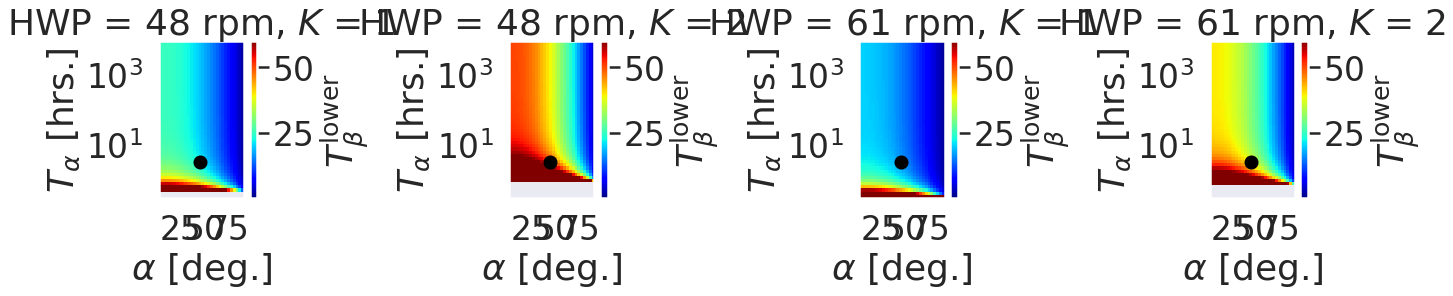

In [4]:
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
for i in range(4):
    ax = axes[i]
    temp = data[i]["T_spin"]/60
    temp[data[i]["T_spin"]<0] = np.nan
    P = ax.pcolormesh(data[i]["Alpha"], data[i]["T_prec"]/60/60, temp, cmap="jet", vmin=0.1, vmax=60)
    ax.scatter(45, 192.348/60, color="black")
    ax.set_xlabel(r"$\alpha$ [deg.]")
    ax.set_ylabel(r"$T_{\alpha}$ [hrs.]")
    ax.set_title("HWP = {} rpm, $K$ = {}".format(hwp_config[i], rot_config[i]))
    ax.set_yscale("log")
    fig.colorbar(P, ax=ax, label=r"$T_\beta^{\rm{lower}}$")
plt.tight_layout()

/tmp/ipykernel_80498/2221685210.py:4: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  P = ax.pcolormesh(data[i]["Alpha"], data[i]["T_prec"]/60/60, data[i]["hitmap_std"], cmap="jet", vmin=0, vmax=1000)
/tmp/ipykernel_80498/2221685210.py:10: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  fig.colorbar(P, ax=ax, label=r"$T_\beta^{\rm{lower}}$")


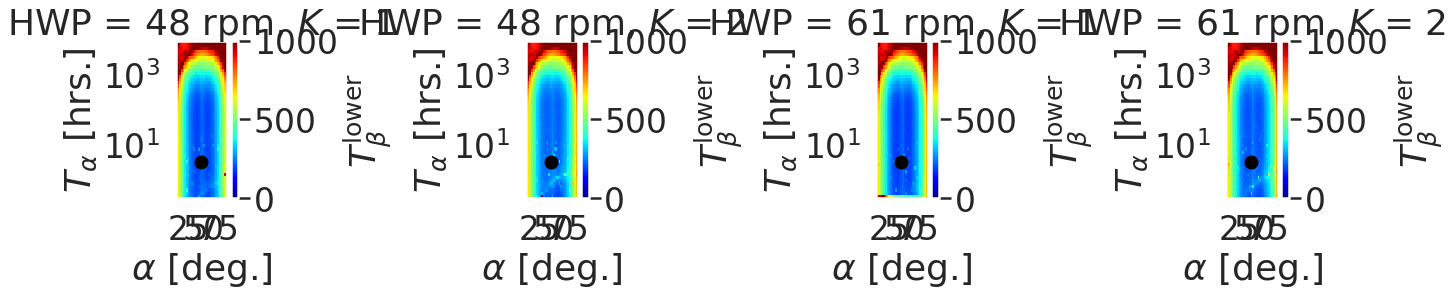

In [5]:
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
for i in range(4):
    ax = axes[i]
    P = ax.pcolormesh(data[i]["Alpha"], data[i]["T_prec"]/60/60, data[i]["hitmap_std"], cmap="jet", vmin=0, vmax=1000)
    ax.scatter(45, 192.348/60, color="black")
    ax.set_xlabel(r"$\alpha$ [deg.]")
    ax.set_ylabel(r"$T_{\alpha}$ [hrs.]")
    ax.set_title("HWP = {} rpm, $K$ = {}".format(hwp_config[i], rot_config[i]))
    ax.set_yscale("log")
    fig.colorbar(P, ax=ax, label=r"$T_\beta^{\rm{lower}}$")
plt.tight_layout()

/tmp/ipykernel_80498/1550362528.py:3: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  P = ax.pcolormesh(data[3]["Alpha"], data[3]["T_prec"]/60/60, data[3]["hitmap_std"], cmap="jet", vmin=0, vmax=1000)
/tmp/ipykernel_80498/1550362528.py:9: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  fig.colorbar(P, ax=ax, label=r"$\sigma_{\mathrm{hits}}$")


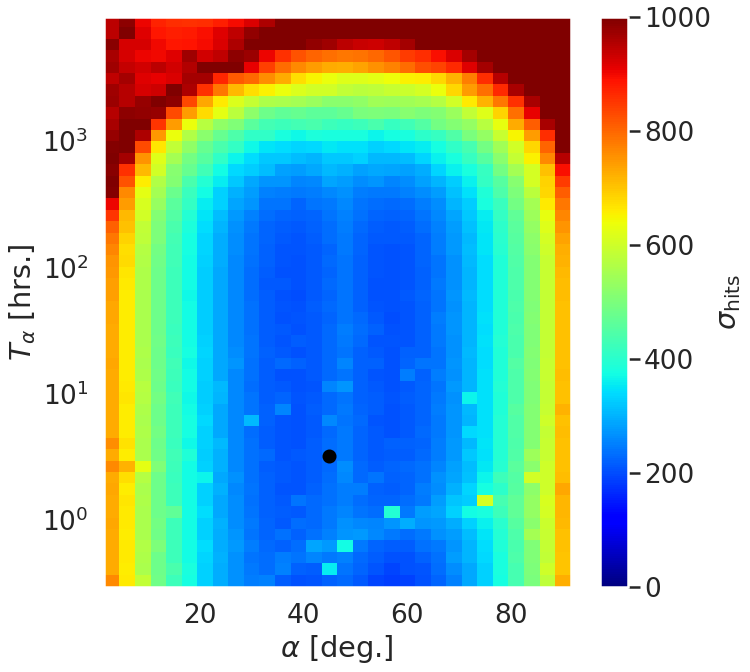

In [58]:
fig, ax = plt.subplots(1, 1, figsize=(11, 10))
#ax = axes[i]
P = ax.pcolormesh(data[3]["Alpha"], data[3]["T_prec"]/60/60, data[3]["hitmap_std"], cmap="jet", vmin=0, vmax=1000)
ax.scatter(45, 192.348/60, color="black")
ax.set_xlabel(r"$\alpha$ [deg.]")
ax.set_ylabel(r"$T_{\alpha}$ [hrs.]")
#ax.set_title("HWP = {} rpm, $K$ = {}".format(hwp_config[i], rot_config[i]))
ax.set_yscale("log")
fig.colorbar(P, ax=ax, label=r"$\sigma_{\mathrm{hits}}$")
plt.tight_layout()
fig.savefig("./SD_of_hitmap.pdf")

/tmp/ipykernel_80498/3120418919.py:13: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  P = ax.pcolormesh(data[k]["Alpha"], data[k]["T_prec"]/60/60, temp, cmap="jet", norm=norm)
/tmp/ipykernel_80498/3120418919.py:19: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  fig.colorbar(P, ax=ax, label=r"$\leftangle |_{nm}\tilde{h}|^2 \rightangle$")


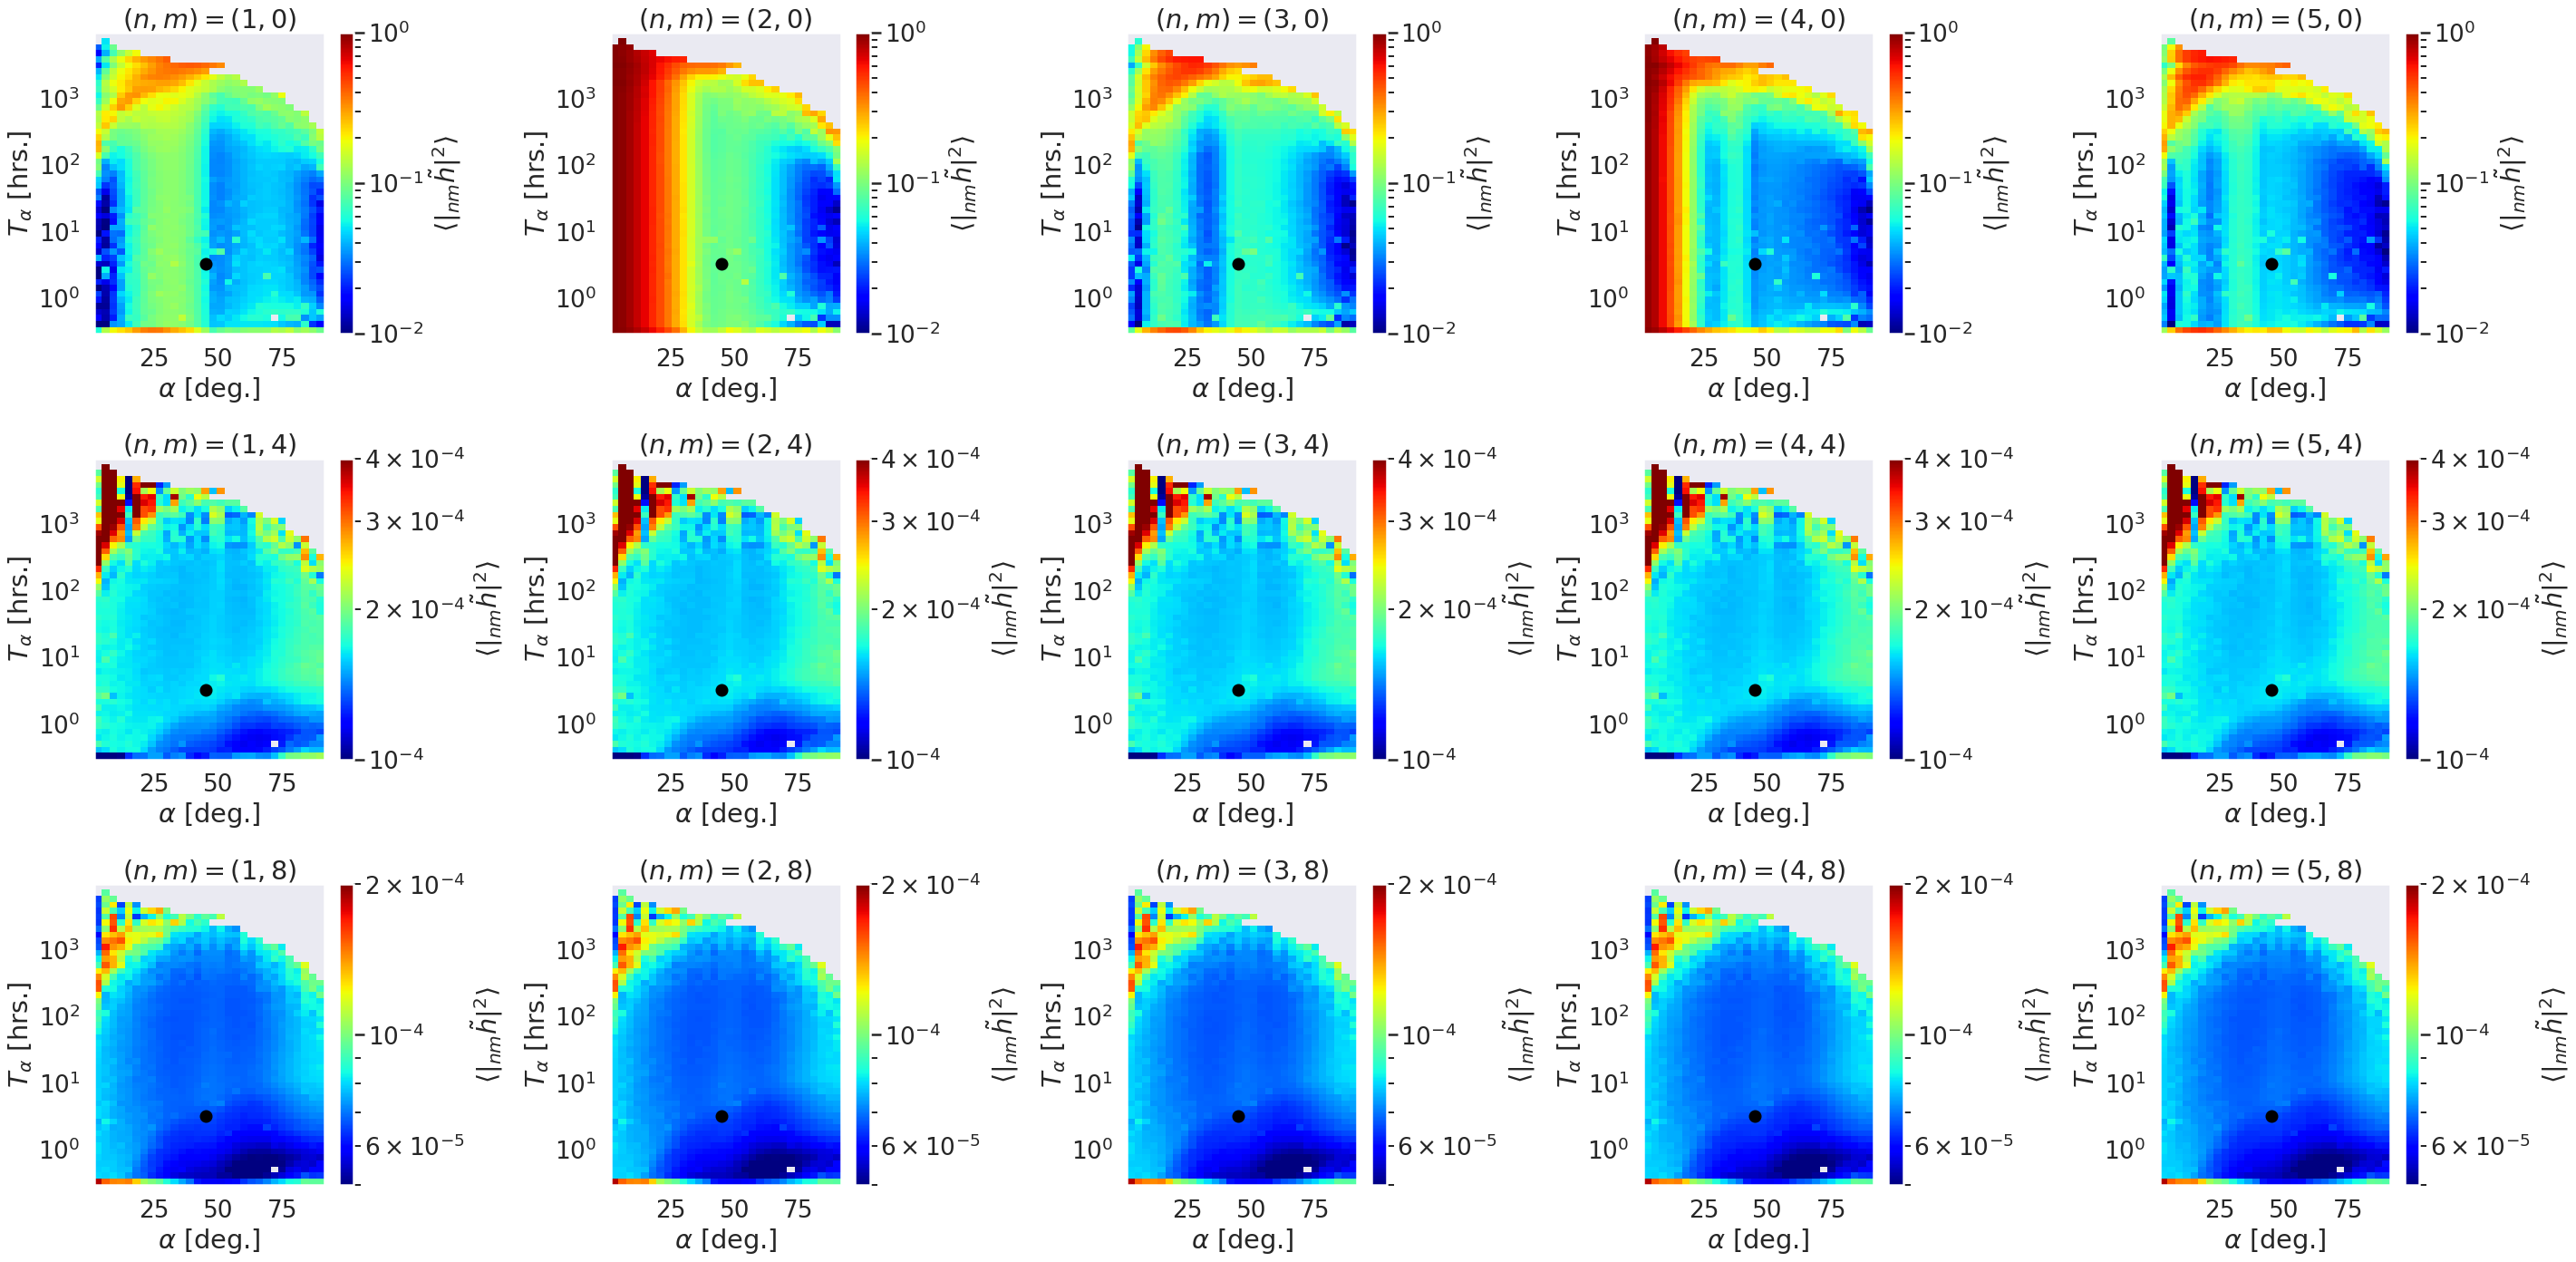

In [69]:
sns.set_context("poster", 1.2, {"lines.linewidth": 1.0})
vmax = [1, 4e-4, 2e-4]
vmin = [1e-2, 1e-4, 5e-5]
for k in [2]: #[0,1,2,3]で全てのケースをプロットできる
    fig, axes = plt.subplots(3, 5, figsize=(40, 20))
    #fig.suptitle("HWP = {} rpm, $K$ = {}".format(hwp_config[k], rot_config[k]))
    for i in range(3):
        for j in range(5):
            ax = axes[i, j]
            norm = mcolors.LogNorm(vmin=vmin[i], vmax=vmax[i])
            temp = data[k]["xlink_mean"][:,:,f(path, j+1,i*4)]
            temp[data[k]["T_spin"]<0] = np.nan
            P = ax.pcolormesh(data[k]["Alpha"], data[k]["T_prec"]/60/60, temp, cmap="jet", norm=norm)
            ax.scatter(45, 192.348/60, color="black")
            ax.set_xlabel(r"$\alpha$ [deg.]")
            ax.set_ylabel(r"$T_{\alpha}$ [hrs.]")
            ax.set_title("$(n,m)=({},{})$".format(j+1,i*4))
            ax.set_yscale("log")
            fig.colorbar(P, ax=ax, label=r"$\leftangle |_{nm}\tilde{h}|^2 \rightangle$")
    plt.tight_layout()
    fig.savefig("./HWP{}rpm_K{}.pdf".format(hwp_config[k], rot_config[k]))

/tmp/ipykernel_80498/3002265005.py:5: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  P = ax.pcolormesh(data[i]["Alpha"], data[i]["T_prec"]/60/60, data[i]["delta_r"], cmap="jet", norm=norm)
/tmp/ipykernel_80498/3002265005.py:6: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  fig.colorbar(P, ax=ax, label=r"$\Delta r$")


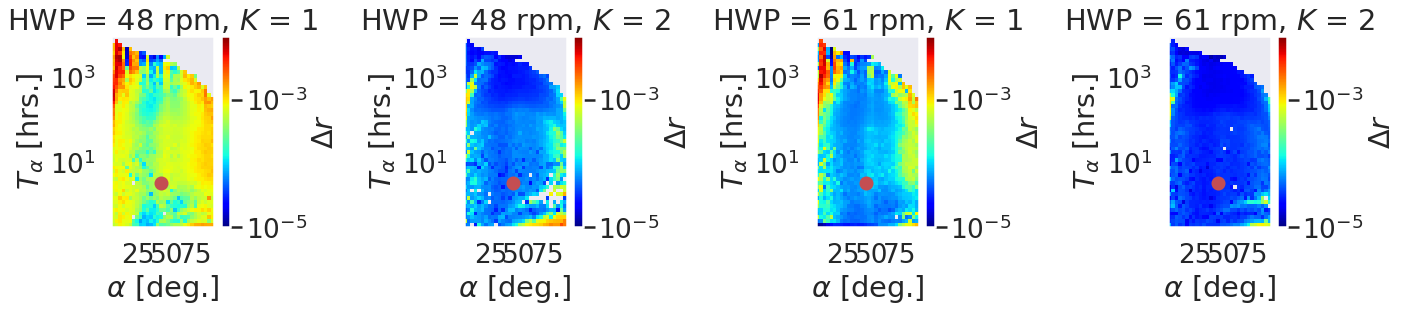

In [44]:
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
for i in range(4):
    ax = axes[i]
    norm = mcolors.LogNorm(vmin=1e-5, vmax=1e-2)
    P = ax.pcolormesh(data[i]["Alpha"], data[i]["T_prec"]/60/60, data[i]["delta_r"], cmap="jet", norm=norm)
    fig.colorbar(P, ax=ax, label=r"$\Delta r$")
    ax.scatter(45, 192.348/60, color="r")
    ax.set_xlabel(r"$\alpha$ [deg.]")
    ax.set_ylabel(r"$T_{\alpha}$ [hrs.]")
    ax.set_yscale("log")
    ax.set_title("HWP = {} rpm, $K$ = {}".format(hwp_config[i], rot_config[i]))
    plt.tight_layout()

/tmp/ipykernel_80498/4234178108.py:3: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  P = ax.pcolormesh(data[2]["Alpha"], data[2]["T_prec"]/60/60, data[2]["delta_r"], cmap="jet", norm=norm)
/tmp/ipykernel_80498/4234178108.py:9: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  fig.colorbar(P, ax=ax, label=r"$\Delta r$")


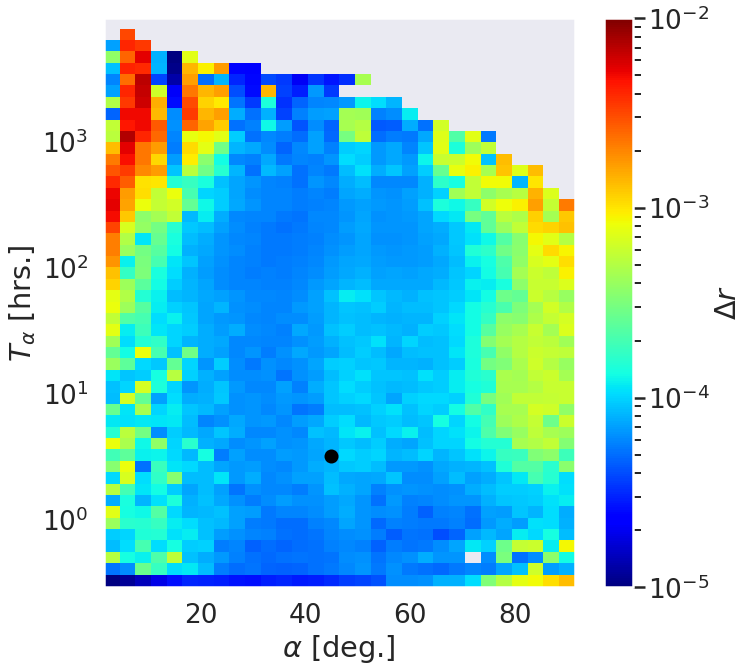

In [62]:
fig, ax = plt.subplots(1, 1, figsize=(11, 10))
norm = mcolors.LogNorm(vmin=1e-5, vmax=1e-2)
P = ax.pcolormesh(data[2]["Alpha"], data[2]["T_prec"]/60/60, data[2]["delta_r"], cmap="jet", norm=norm)
ax.scatter(45, 192.348/60, color="black")
ax.set_xlabel(r"$\alpha$ [deg.]")
ax.set_ylabel(r"$T_{\alpha}$ [hrs.]")
#ax.set_title("HWP = {} rpm, $K$ = {}".format(hwp_config[i], rot_config[i]))
ax.set_yscale("log")
fig.colorbar(P, ax=ax, label=r"$\Delta r$")
plt.tight_layout()
fig.savefig("./delta_r.pdf")

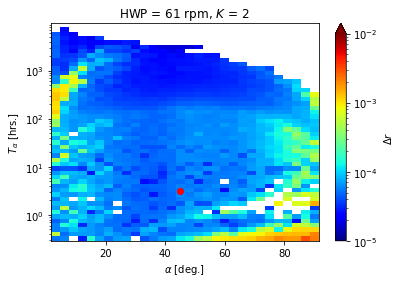

In [21]:
i = 1
fig = plt.figure()
ax = fig.add_subplot(111)
#ax.set_title("Pointing offset 1 arcmin")
ax.set_title("HWP = {} rpm, $K$ = {}".format(hwp_config[k], rot_config[k]))
norm = mcolors.LogNorm(vmin=1e-5, vmax=1e-2)
P = plt.pcolormesh(data[i]["Alpha"], data[i]["T_prec"]/60/60, data[i]["delta_r"], cmap="jet", norm=norm)
cbar = plt.colorbar(P, ax=ax, extend="max", label=r"$\Delta r$")
plt.scatter(45, 192.348/60, color="r")
ax.set_xlabel(r"$\alpha$ [deg.]")
ax.set_ylabel(r"$T_{\alpha}$ [hrs.]")
ax.set_yscale("log")

In [ ]:
Max = np.zeros([3,5])
Min = np.zeros([3,5])
for i in range(3):
    for j in range(5):
        Max[i,j] = np.nanmax(data["xlink_mean"][:,:,f(path, j+1,i*4)])
        Min[i,j] = np.nanmin(data["xlink_mean"][:,:,f(path, j+1,i*4)])
vmax = np.round(Max.max(1), 5)
vmin = np.round(Max.min(1), 5)

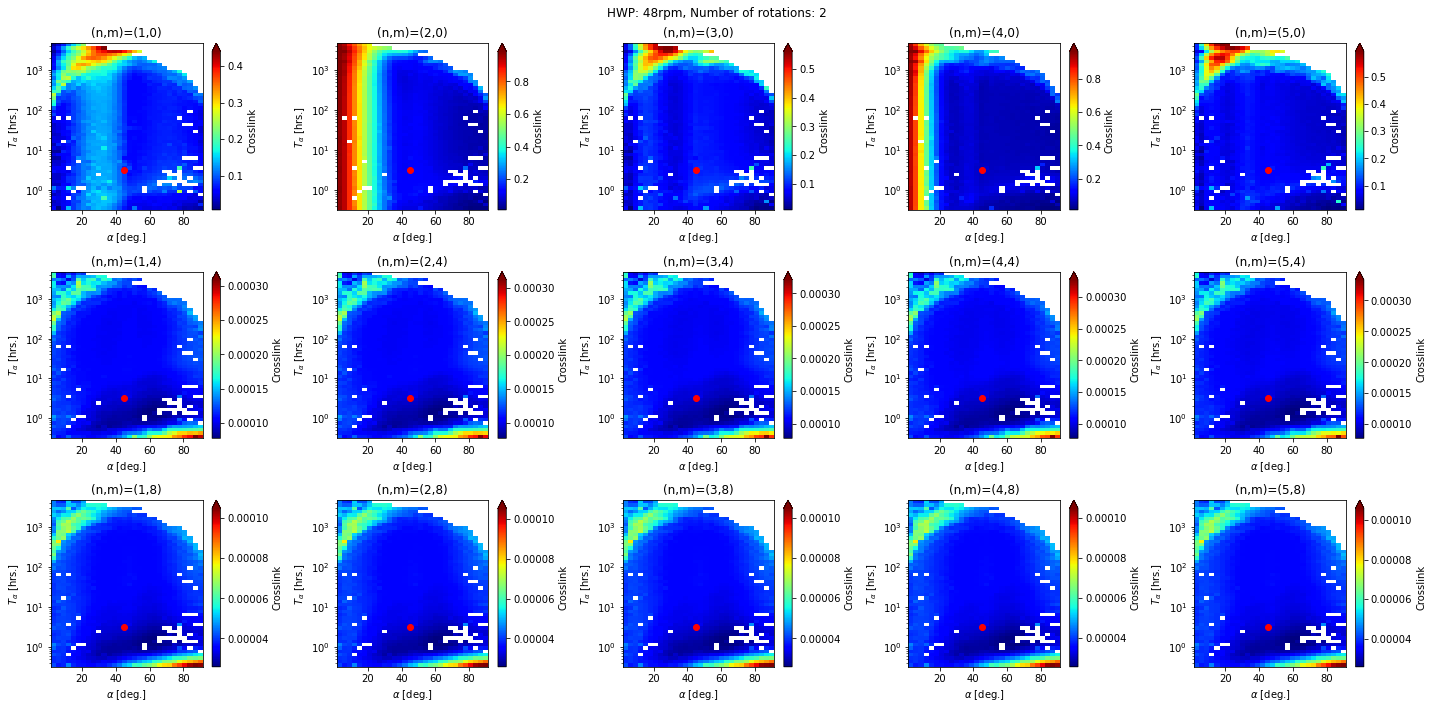

In [109]:
fig, axes = plt.subplots(3, 5, figsize=(20, 10))
fig.suptitle("HWP: {}rpm, Number of rotations: {}".format(hwprpm, numofrot))
for i in range(3):
    for j in range(5):
        ax = axes[i, j]
        P = ax.pcolormesh(data["Alpha"], data["T_prec"]/60/60, data["xlink_mean"][:,:,f(path, j+1,i*4)], cmap="jet")
        ax.scatter(45, 192.348/60, color="r")
        ax.set_xlabel(r"$\alpha$ [deg.]")
        ax.set_ylabel(r"$T_{\alpha}$ [hrs.]")
        ax.set_title("(n,m)=({},{})".format(j+1,i*4))
        ax.set_yscale("log")
        fig.colorbar(P, ax=ax, extend="max", label=r"Crosslink")
plt.tight_layout()

In [16]:
data = get_hitmap(path+"/output_675.h5")
nside = 256
maps = np.zeros(hp.nside2npix(nside))
maps[data["hitmap"]==0] = 1
hp.mollview(data["hitmap"], norm="none", coord=("G","E"))
hp.mollview(maps, norm="hist", coord=("G","E"))
print("alpha     : ", data["ss"]["alpha"])
print("beta      : ", data["ss"]["beta"])
precmin = rpm_to_period(data["ss"]["prec_rpm"])/60
spinmin = rpm_to_period(data["ss"]["spin_rpm"])/60
print("prec min  : ", precmin)
print("spin min  : ", spinmin)
print("prec/spin : ", precmin/spinmin)

KeyError: "Unable to open object (object 'hitmap' doesn't exist)"